<a href="https://colab.research.google.com/github/msageha/deeplearning_from_scratch/blob/master/deeplearning_from_scratch_2/section_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!curl https://gist.githubusercontent.com/msageha/1765bd85b8f1e18141e7bff5982995a4/raw/bb20bc16d48cab6e08dcdbc6b5711e3edf356b73/initialize_google_colaboratory.sh | sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    86  100    86    0     0   1075      0 --:--:-- --:--:-- --:--:--  1075
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0  13790      0 --:--:-- --:--:-- --:--:-- 13790
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-9-2 is already the newest version (9.2.148-1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
+ pip install -q cupy-cuda92  chainer 
+ set +ex
Installation succeeded!


In [12]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-2.git

fatal: destination path 'deep-learning-from-scratch-2' already exists and is not an empty directory.


In [0]:
import sys
sys.path.append('./deep-learning-from-scratch-2')
import numpy as np
import matplotlib.pyplot as plt

GPU = True
xp = np
if GPU:
  try:
    import cupy as cp
    xp = cp
  except:
    pass

**シグモイド関数**

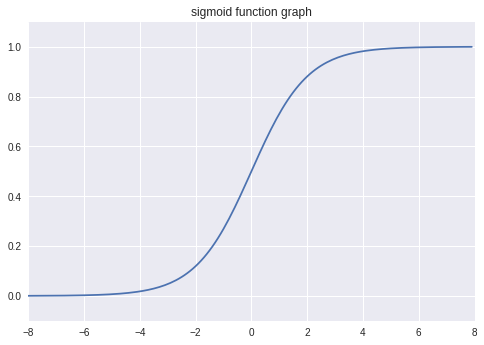

In [14]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def show():
  X = np.arange(-8, 8, 0.1) #-8から8まで0.1刻みの値を配列で生成
  Y = sigmoid(X) #Xの値をシグモイド関数に渡す
  plt.plot(X, Y)
  plt.xlim(-8, 8) #x軸:-8から8までの範囲で表示
  plt.ylim(-0.1, 1.1) #y軸: -0.1から1.1までの範囲で表示
  plt.title("sigmoid function graph")
  plt.show()
 
show()

In [0]:
# Sigmoidレイヤ
class Sigmoid:
  def __init__(self):
    self.params, self.grads = [], []
    self.out = None
    
  def forward(self, x):
    out = 1 / (1  + xp.exp(-x))
    self.out = out
    return out
  
  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out
    return dx
  
# Affineレイヤ
class Affine:
  def __init__(self, W, b):
    self.params = [W, b]
    self.grads = [xp.zeros_like(W), xp.zeros_like(b)]
    self.x = None
    
  def forward(self, x):
    W, b = self.params
    out = xp.dot(x, W) + b
    self.x = x
    return out
  
  def backward(self, dout):
    W, b = self.params
    dx = xp.dot(dout, W.T)
    dW = xp.dot(self.x.T, dout)
    db = xp.sum(dout, axis=0)
    
    self.grads[0][...] = dW
    self.grads[1][...] = db
    return dx

# ochastic Gradiexlt Descent:確 率的勾配降下法
class SGD:
  def __init__(self, lr=0.01):
    self.lr = lr
  
  def update(self, params, grads):
    for i in range(len(params)):
      params[i] -= self.lr * grads[i]
      
# softmax関数
def softmax(x):
  if x.ndim == 2:
    x = x - x.max(axis=1, keepdims=True)
    x = xp.exp(x)
    x /= x.sum(axis=1, keepdims=True)
  elif x.ndim == 1:
    x = x - xp.max(x)
    x = xp.exp(x) / xp.sum(xp.exp(x))
  else:
    print('warning!!! unexpected shape x : {}'.format(x.shape))
  return x

#交差エントロピー誤差
def cross_entropy_error(y, t):
  if y.ndim == 1:
    t = t.reshape(1, t.size)
    y = y.reshape(1, y.size)
  
  #教師データがone-hot vectorの場合，正解ラベルのインデックスに変換
  if t.size == y.size:
    t = t.argmax(axis=1)
  
  batch_size = y.shape[0]
  
  return -xp.sum(xp.log(y[xp.arange(batch_size), t] + 1e-7)) / batch_size

class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmaxの出力
        self.t = None  # 教師ラベル

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 教師ラベルがone-hotベクトルの場合、正解のインデックスに変換
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[xp.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size
        
        return dx

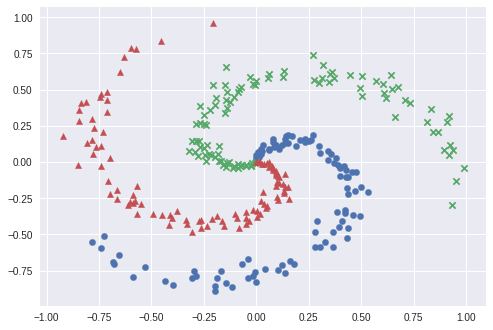

In [16]:
from dataset import spiral
x, t = spiral.load_data()

def show_spiral(x, t):
  CLASS_NUM = 3
  N = 100
  markers = ['o', 'x', '^']
  for i in range(CLASS_NUM):
      plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
  plt.show()

show_spiral(x, t)

# **ニューラルネットワークの実装**

In [0]:
class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size):
    #重みとバイアスの初期化
    W1 = 0.01 * xp.random.randn(input_size, hidden_size)
    b1 = xp.zeros(hidden_size)
    W2 = 0.01 * xp.random.randn(hidden_size, output_size)
    b2 = xp.zeros(output_size)
    
    self.layers = [
        Affine(W1, b1),
        Sigmoid(),
        Affine(W2, b2)
    ]
    self.loss_layer = SoftmaxWithLoss()
    
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.grads += layer.grads
    
  def predict(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    return x
  
  def forward(self, x, t):
    score = self.predict(x)
    loss = self.loss_layer.forward(score, t)
    return loss
  
  def backward(self,  dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

In [18]:
# ハイパーパラメータの設定
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

#モデル読み込み，最適化関数読み込み
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 学習で使用する変数
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

x, t = spiral.load_data()
x = xp.array(x)
t = xp.array(t)

import time
start = time.time()

for epoch in range(max_epoch):
    # データのシャッフル
    idx = xp.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

        # 定期的に学習経過を出力
        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print('| epoch %d |  iter %d / %d | loss %.2f'
                  % (epoch + 1, iters + 1, max_iters, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0
print(time.time() - start)

| epoch 1 |  iter 10 / 10 | loss 1.14
| epoch 2 |  iter 10 / 10 | loss 1.17
| epoch 3 |  iter 10 / 10 | loss 1.17
| epoch 4 |  iter 10 / 10 | loss 1.12
| epoch 5 |  iter 10 / 10 | loss 1.18
| epoch 6 |  iter 10 / 10 | loss 1.16
| epoch 7 |  iter 10 / 10 | loss 1.12
| epoch 8 |  iter 10 / 10 | loss 1.12
| epoch 9 |  iter 10 / 10 | loss 1.10
| epoch 10 |  iter 10 / 10 | loss 1.11
| epoch 11 |  iter 10 / 10 | loss 1.09
| epoch 12 |  iter 10 / 10 | loss 1.10
| epoch 13 |  iter 10 / 10 | loss 1.09
| epoch 14 |  iter 10 / 10 | loss 1.03
| epoch 15 |  iter 10 / 10 | loss 1.01
| epoch 16 |  iter 10 / 10 | loss 0.97
| epoch 17 |  iter 10 / 10 | loss 0.96
| epoch 18 |  iter 10 / 10 | loss 0.92
| epoch 19 |  iter 10 / 10 | loss 0.89
| epoch 20 |  iter 10 / 10 | loss 0.87
| epoch 21 |  iter 10 / 10 | loss 0.85
| epoch 22 |  iter 10 / 10 | loss 0.85
| epoch 23 |  iter 10 / 10 | loss 0.80
| epoch 24 |  iter 10 / 10 | loss 0.79
| epoch 25 |  iter 10 / 10 | loss 0.78
| epoch 26 |  iter 10 / 10 | loss 

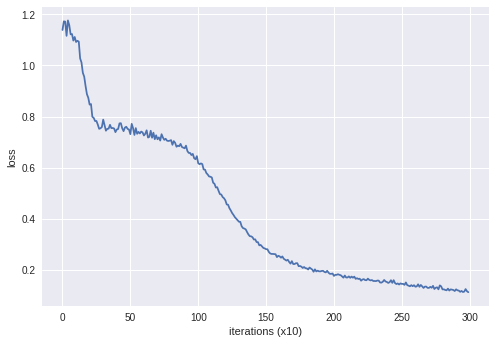

In [19]:
# 学習結果のプロット
def show_loss(loss_list):
  plt.plot(np.arange(len(loss_list)), loss_list, label='train')
  plt.xlabel('iterations (x10)')
  plt.ylabel('loss')
  plt.show()

show_loss(loss_list)

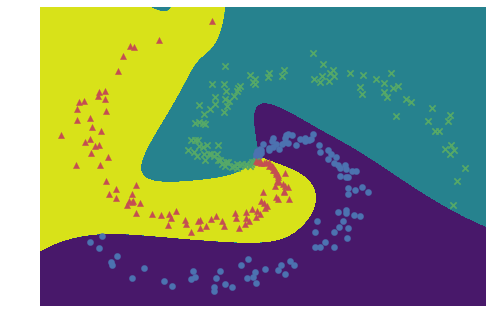

In [30]:
#境界領域のプロット
def show_territory(x, t):
  h = 0.001
  #グラフ領域の設定
  x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
  y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
  
  xx, yy = xp.meshgrid(xp.arange(x_min, x_max, h), xp.arange(y_min, y_max, h))
  X = xp.c_[xx.ravel(), yy.ravel()]
  score = model.predict(X)
  predict_cls = xp.argmax(score, axis=1)
  Z = predict_cls.reshape(xx.shape)
  if GPU:
    Z = np.array(Z.get())
    xx = np.array(xx.get())
    yy = np.array(yy.get())
  plt.contourf(xx, yy, Z, cmap='viridis')
  plt.axis('off')
  show_spiral(x, t)

x, t = spiral.load_data()
show_territory(x, t)